In [41]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from utils.preprocessing import *
import sys

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

from keras.backend import *
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior() # enables np methods on tensors

In [42]:
#testing_dir = '../data/C-NMC_Leukemia/testing_data/C-NMC_test_final_phase_data' ### WE DO NOT USE THIS
training_dir_base = f'../data/C-NMC_Leukemia/training_data/' 
fold_0_all_path = 'fold_0/all'
fold_0_hem_path = 'fold_0/hem'
fold_1_all_path = 'fold_1/all'
fold_1_hem_path = 'fold_1/hem'

In [43]:
### The code for this lives in notebooks.utils.preprocessing
### Get grayscale images as tensors, and labels for both classes
img_train_cancer = get_gray_images(training_dir_base+fold_0_all_path)
img_train_healthy = get_gray_images(training_dir_base+fold_0_hem_path)
train_health_labels = [0 for _ in range(len(img_train_healthy))]
train_cancer_labels = [1 for _ in range(len(img_train_cancer))]

## Distance-Based Classification

In [38]:
import random
from tqdm import tqdm
# measure concavity of images in inData with a binarization cutoff
def findConcavity(inData, cutoff, image_size):
    # array of concavity measures
    concavity = np.array(np.zeros(len(inData)))

    # find concavity of each image
    for i in tqdm(range(len(inData))): ### NOTE: This will give you a loading bar and estimated run time
        # binarize image
        binarized = np.array(tf.Variable(inData[i]))
        ### NOTE: You should be able to do vectorized comparison to speed this up
        ### NOTE: Something like (binarized < cutoff).astype(int) -> np.array of 1's and 0's
        for x in range(image_size):
            for y in range(image_size):
                if binarized[x][y] < cutoff:
                    binarized[x][y] = 0
                else:
                    binarized[x][y] = 1
        # randomly check for concavity by finding 500 pairs of points in the cell
        point_pair_count = 0 # number of point pairs
        overRun = 0 # keeps the while loop from running infinitely
        while ((point_pair_count < 200) and (overRun < 100000)): # k < 200, overRun < 100000 works well
            overRun += 1 
            x = random.randint(0, image_size - 1)
            y = random.randint(0, image_size - 1)
            u = random.randint(0, image_size - 1)
            v = random.randint(0, image_size - 1)
            if binarized[x][y] * binarized[u][v]: ### NOTE: If statements in python do not need parenthesis
                point_pair_count += 1
                # check line connecting (x, y) to (u, v) for proportion of missing pixels
                xMin = min([x, u])
                xMax = max([x, u])
                run = xMax - xMin
                rise = v - y
                localSum = 0
                for s in range(xMin, xMax):
                    t = int(v+(s-xMin)*rise/(run+.0001)) # don't divide by zero
                    if t < 0:
                        t = 0
                    if t > image_size - 1:
                        t = image_size - 1
                    if binarized[s][t] == 0:
                        localSum  += 1
                concavity[i] += localSum # add concavity

        # DEBUG - See current progress: print(concavity[i], overRun)
        
    return concavity

In [ ]:
import pandas as pd
# get concavity values for healthy and cancer images
healthyConcavity = findConcavity(img_train_healthy, 25, 450)
cancerConcavity = findConcavity(img_train_cancer, 25, 450)

# input test images and labels
img_test = get_gray_images("../data/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data")
test_labels = pd.read_csv("../data/C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv")
# find the concavity of the test images
testConcavity = findConcavity(img_test, 25, 450)



In [13]:
# backing up data
#healthyBackup = np.array(np.zeros(len(healthyConcavity)))
#for i in range(len(healthyConcavity)):
#    healthyBackup[i] = healthyConcavity[i]
#cancerBackup = np.array(np.zeros(len(cancerConcavity)))
#for i in range(len(cancerConcavity)):
#    cancerBackup[i] = healthyConcavity[i]
#testBackup = np.array(np.zeros(len(testConcavity)))
#for i in range(len(testConcavity)):
#    testBackup[i] = testConcavity[i]

Healthy concavity quartiles: [2248. 2548. 2925.]
Cancer concavity quartiles: [2724. 3064. 3469.]
Cutoff halfway between upper quartile of healthy and lower quartile of cancer: [2824.5]
Correctly identified cancerous cells: 108
Total cancerous cells: 347
Correctly identified healthy cells: 459
Total healthy cells: 654
Accuracy: 0.5664335664335665


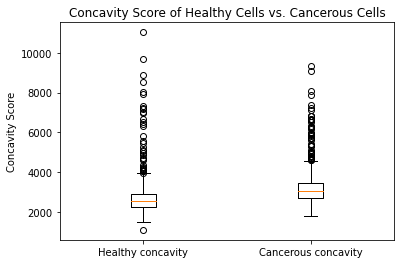

In [ ]:
# find quartile ranges
plt.boxplot([healthyConcavity,cancerConcavity], labels = ['Healthy concavity', 'Cancerous concavity'])
plt.title('Concavity Score of Healthy Cells vs. Cancerous Cells')
#plt.xlabel("Healthy vs. Cancerous")
plt.ylabel("Concavity Score")
print("Healthy concavity quartiles:", np.quantile(healthyConcavity, [.25, .5, .75]))
print("Cancer concavity quartiles:", np.quantile(cancerConcavity, [.25, .5, .75]))

# get cutoff value halfway between upper quartile of healthy and lower quartile of cancerous
cutoff = (np.quantile(healthyConcavity, [.75]) + np.quantile(cancerConcavity, [.25]))/2
print("Cutoff halfway between upper quartile of healthy and lower quartile of cancer:", cutoff)

# concavity < cutoff is computed as healthy (0), cancer (1) otherwise
computedClasses = np.array(np.zeros(len(testConcavity)))
for i in range(len(testConcavity)):
    if testConcavity[i] < cutoff:
        computedClasses[i] = 0
    else:
        computedClasses[i] = 1

# validate against known labels
correctCancer = 0
totalCancer = 0
correctHealthy = 0
totalHealthy = 0
for i in range(len(testConcavity)):
    if test_labels['labels'].loc[i] == 0:
        totalCancer += 1
        if computedClasses[i] == 0:
            correctCancer += 1
    if test_labels['labels'].loc[i] == 1:
        totalHealthy += 1
        if computedClasses[i] == 1:
            correctHealthy += 1
            
print("Correctly identified cancerous cells:", correctCancer)
print("Total cancerous cells:", totalCancer)
print("Correctly identified healthy cells:", correctHealthy)
print("Total healthy cells:", totalHealthy)
print("Accuracy:", (correctCancer+correctHealthy)/(totalCancer+totalHealthy))

#DEBUG - confusion_matrix = metrics.confusion_matrix(test_labels['labels'].loc[:20], computedClasses[:21])
confusion_matrix = metrics.confusion_matrix(test_labels['labels'].loc[:1000], computedClasses)
px.imshow(
    confusion_matrix, text_auto=True,
    labels=dict(x="Confusion Matrix: Distance Based Classification"),
    x=['Actual Positive', 'Actual Negative'],
    y=['Predicted Positive', 'Predicted Negative']
)

## Random Forests

In [44]:
def randomForestAccuracy(img_cancer, img_healthy, labels_healthy, labels_cancer, nest=100, mssplit=2, mleaf=1):
    ### For random forests, X is our combined image set and y is our combined label set.
    X =  np.array(img_cancer + img_healthy)
    y = np.array(labels_cancer + labels_healthy)

    ### train-test-split our data, and initialize the forest.
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)

    forest = RandomForestClassifier(n_estimators=nest, random_state=100, min_samples_split=mssplit, min_samples_leaf=mleaf)

    ### The random forests algorithm expects 2 dimensional data at the most.
    ### We can accomplish this on our 4-dimensional data by multiplying the last 3 dimensions together to flatten the data
    X_shape = X_train.shape
    X_tshape = X_test.shape
    X_train = X_train.reshape(X_shape[0], X_shape[1] * X_shape[2] * X_shape[3])
    X_test = X_test.reshape(X_tshape[0], X_tshape[1] * X_tshape[2] * X_tshape[3])

    ### Fit the random forest, try it on the test data, and assess the model's accuracy
    forest.fit(X_train,y_train)
    predictions = forest.predict(X_test)
    return metrics.accuracy_score(y_test, predictions), forest, predictions, y_test

In [45]:
accuracy_original, rf_model, predictions, labels = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels)

In [46]:
confusion_matrix = metrics.confusion_matrix(labels, predictions)
px.imshow(
    confusion_matrix, text_auto=True,
    labels=dict(x="Confusion Matrix Random Forest"),
    x=['Positive', 'Negative'],
    y=['Positive', 'Negative']
)

In [47]:
### Random forests, color
### We will repeat the steps above, with color images instead.
img_train_cancer = get_gray_images(training_dir_base+fold_0_all_path, 128)
img_train_healthy = get_gray_images(training_dir_base+fold_0_hem_path, 128)

In [48]:
accuracy_128 = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels)

In [49]:
### I find that there is a negligible (0.4%) difference between full size and 128x128 downscaled images.
### Because downscaled images process faster, I will use those
print(accuracy_original)
print(accuracy_128[0])

0.8202995008319468
(0.8202995008319468, RandomForestClassifier(random_state=100), array([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1,

In [12]:
### Assemble combinations of hyperparameters for tuning.
from itertools import product
_n_estimators = [50, 100, 150]
_min_samples_split = [2, 5, 10]
_min_samples_leaf = [1, 2, 5]
list_of_lists = [_n_estimators, _min_samples_split, _min_samples_leaf]
all_combinations = list(product(*list_of_lists))

In [14]:
### Find the highest accuracy combination of hyperparameters.
max_accuracy = -1
max_accuracy_params = []
for combination in all_combinations:
    accuracy, rf_model, rf_preds, rf_real  = randomForestAccuracy(img_train_cancer, img_train_healthy, train_health_labels, train_cancer_labels, 
                                    nest=combination[0], mssplit=combination[1], mleaf=combination[2])
    
    if accuracy > max_accuracy:
        max_accuracy = accuracy
        max_accuracy_params = combination

In [15]:
print(max_accuracy)
print(max_accuracy_params)

0.8435940099833611
(50, 5, 1)


# Perceptron

Perceptron: Grayscale Images

In [16]:
grayCancer = get_gray_images(training_dir_base+fold_0_all_path)
grayHealthy = get_gray_images(training_dir_base+fold_0_hem_path)

trainCancerLabels = [1 for _ in range(len(grayCancer))]
trainHealthLabels = [0 for _ in range(len(grayHealthy))]

images, labels = grayCancer + grayHealthy, trainCancerLabels + trainHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
grayImages = np.array(images).reshape(len(images), 450, 450)
grayLabels = np.array(labels)

In [17]:
# shuffle labels and images in unison so they maintain their image-label correspondance
randomize = np.arange(len(grayImages))
np.random.shuffle(randomize)
grayImages = grayImages[randomize]
grayLabels = grayLabels[randomize]

In [18]:
with tf.device('/CPU:0'): # tf uses GPU by default, use this if your config is out of whack like mine is -C.J.
                            # otherwise use - with tf.device('/GPU:0) or remove code from under with statement
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = [450, 450]),
        tf.keras.layers.Dense(1, activation='sigmoid'), # Dense operation is output = activation(dot(input, kernel) + bias)
    ])

    model.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(),                
                metrics=['accuracy'])

    #print(images.shape, labels.shape)

    model.fit(grayImages, grayLabels, epochs = 10, batch_size = 10)

Epoch 1/10
201/201 [==============================] - 1s 4ms/step - loss: 123.8837 - accuracy: 0.7018
Epoch 2/10
201/201 [==============================] - 1s 5ms/step - loss: 102.7819 - accuracy: 0.7263
Epoch 3/10
201/201 [==============================] - 1s 4ms/step - loss: 84.0012 - accuracy: 0.7468
Epoch 4/10
201/201 [==============================] - 1s 4ms/step - loss: 103.8687 - accuracy: 0.7433
Epoch 5/10
201/201 [==============================] - 1s 4ms/step - loss: 111.6522 - accuracy: 0.7498
Epoch 6/10
201/201 [==============================] - 1s 4ms/step - loss: 58.2578 - accuracy: 0.7882
Epoch 7/10
201/201 [==============================] - 1s 4ms/step - loss: 54.3200 - accuracy: 0.7917
Epoch 8/10
201/201 [==============================] - 1s 4ms/step - loss: 51.7777 - accuracy: 0.8072
Epoch 9/10
201/201 [==============================] - 1s 4ms/step - loss: 55.9597 - accuracy: 0.7962
Epoch 10/10
201/201 [==============================] - 1s 3ms/step - loss: 42.0522 - ac

In [19]:
### Create testing data
grayCancerTest = get_gray_images(training_dir_base+fold_1_all_path)
grayHealthyTest = get_gray_images(training_dir_base+fold_1_hem_path)

testCancerLabels = [1 for _ in range(len(grayCancerTest))]
testHealthLabels = [0 for _ in range(len(grayHealthyTest))]

images, labels = grayCancerTest + grayHealthyTest, testCancerLabels + testHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
grayImagesTest = np.array(images).reshape(len(images), 450, 450)
grayLabelsTest = np.array(labels)

In [20]:
### Test model on test data
model.evaluate(grayImagesTest, grayLabelsTest)

63/63 [==============================] - 0s 5ms/step - loss: 226.7651 - accuracy: 0.5679


[226.76513671875, 0.5679320693016052]

Perceptron: HSV Images

In [21]:
hsvCancer = get_hsv_images(training_dir_base+fold_0_all_path)
hsvHealthy = get_hsv_images(training_dir_base+fold_0_hem_path)

trainCancerLabels = [1 for _ in range(len(hsvCancer))]
trainHealthLabels = [0 for _ in range(len(hsvHealthy))]

images, labels = hsvCancer + hsvHealthy, trainCancerLabels + trainHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
hsvImages = np.array(images).reshape(len(images), 450, 450, 3)
hsvLabels = np.array(labels)
#plt.imshow(hsvImages[0])

In [22]:
# shuffle labels and images in unison so they maintain their image-label correspondance
randomize = np.arange(len(hsvImages))
np.random.shuffle(randomize)
hsvImages = hsvImages[randomize]
hsvLabels = hsvLabels[randomize]

In [23]:
with tf.device('/CPU:0'): 
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = [450, 450, 3]),
        tf.keras.layers.Dense(1, activation='sigmoid'), # Dense operation is output = activation(dot(input, kernel) + bias)
    ])

    model.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(),                
                metrics=['accuracy'])

    model.fit(hsvImages, hsvLabels, epochs = 10, batch_size = 10)

Epoch 1/10
201/201 [==============================] - 2s 10ms/step - loss: 237.5591 - accuracy: 0.7003
Epoch 2/10
201/201 [==============================] - 2s 10ms/step - loss: 138.6336 - accuracy: 0.7193
Epoch 3/10
201/201 [==============================] - 2s 10ms/step - loss: 180.6933 - accuracy: 0.7283
Epoch 4/10
201/201 [==============================] - 2s 8ms/step - loss: 77.0337 - accuracy: 0.7752
Epoch 5/10
201/201 [==============================] - 2s 8ms/step - loss: 111.6264 - accuracy: 0.7512
Epoch 6/10
201/201 [==============================] - 2s 8ms/step - loss: 143.2562 - accuracy: 0.7812
Epoch 7/10
201/201 [==============================] - 2s 9ms/step - loss: 130.7946 - accuracy: 0.7732
Epoch 8/10
201/201 [==============================] - 2s 9ms/step - loss: 140.3940 - accuracy: 0.7797
Epoch 9/10
201/201 [==============================] - 2s 9ms/step - loss: 140.7160 - accuracy: 0.7792
Epoch 10/10
201/201 [==============================] - 2s 9ms/step - loss: 87.96

In [24]:
### Create testing data
hsvCancerTest = get_hsv_images(training_dir_base+fold_1_all_path)
hsvHealthyTest = get_hsv_images(training_dir_base+fold_1_hem_path)

testCancerLabels = [1 for _ in range(len(hsvCancerTest))]
testHealthLabels = [0 for _ in range(len(hsvHealthyTest))]

images, labels = hsvCancerTest + hsvHealthyTest, testCancerLabels + testHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
hsvImagesTest = np.array(images).reshape(len(images), 450, 450, 3)
hsvLabelsTest = np.array(labels)

In [25]:
### Test model on test data
model.evaluate(hsvImagesTest, hsvLabelsTest)

63/63 [==============================] - 2s 15ms/step - loss: 196.6108 - accuracy: 0.6553


[196.61080932617188, 0.6553446650505066]

Perceptron: Saturated Images

In [26]:
satCancer = get_saturated_images(training_dir_base+fold_0_all_path)
satHealthy = get_saturated_images(training_dir_base+fold_0_hem_path)

trainCancerLabels = [1 for _ in range(len(satCancer))]
trainHealthLabels = [0 for _ in range(len(satHealthy))]

images, labels = satCancer + satHealthy, trainCancerLabels + trainHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
satImages = np.array(images).reshape(len(images), 450, 450, 3)
satLabels = np.array(labels)

In [27]:
# shuffle labels and images in unison so they maintain their image-label correspondance
randomize = np.arange(len(satImages))
np.random.shuffle(randomize)
satImages = satImages[randomize]
satLabels = satLabels[randomize]

In [28]:
with tf.device('/CPU:0'): 
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(input_shape = [450, 450, 3]),
        tf.keras.layers.Dense(1, activation='sigmoid'), # Dense operation is output = activation(dot(input, kernel) + bias)
    ])

    model.compile(optimizer='adam', 
                loss=tf.keras.losses.BinaryCrossentropy(),                
                metrics=['accuracy'])

    model.fit(satImages, satLabels, epochs = 10, batch_size = 10)

Epoch 1/10
201/201 [==============================] - 3s 12ms/step - loss: 536.8519 - accuracy: 0.6943
Epoch 2/10
201/201 [==============================] - 2s 11ms/step - loss: 354.7921 - accuracy: 0.7428
Epoch 3/10
201/201 [==============================] - 2s 9ms/step - loss: 224.4427 - accuracy: 0.7562
Epoch 4/10
201/201 [==============================] - 2s 9ms/step - loss: 171.2371 - accuracy: 0.7872
Epoch 5/10
201/201 [==============================] - 2s 8ms/step - loss: 148.6500 - accuracy: 0.8057
Epoch 6/10
201/201 [==============================] - 2s 9ms/step - loss: 304.2702 - accuracy: 0.7662
Epoch 7/10
201/201 [==============================] - 2s 8ms/step - loss: 192.0186 - accuracy: 0.8132
Epoch 8/10
201/201 [==============================] - 2s 8ms/step - loss: 199.7527 - accuracy: 0.8092
Epoch 9/10
201/201 [==============================] - 2s 8ms/step - loss: 244.5750 - accuracy: 0.7947
Epoch 10/10
201/201 [==============================] - 2s 8ms/step - loss: 229.1

Perceptron: Saturated Images

In [29]:
### Create testing data
satCancerTest = get_saturated_images(training_dir_base+fold_1_all_path)
satHealthyTest = get_saturated_images(training_dir_base+fold_1_hem_path)

testCancerLabels = [1 for _ in range(len(satCancerTest))]
testHealthLabels = [0 for _ in range(len(satHealthyTest))]

images, labels = satCancerTest + satHealthyTest, testCancerLabels + testHealthLabels # concatenate cancer and healthy images, as well as their labels into combined image and label vectors
images, labels = np.array(images), np.array(labels)

# convert to np arrays for training
satImagesTest = np.array(images).reshape(len(images), 450, 450, 3)
satLabelsTest = np.array(labels)
### usually works, currently expirencing resource exhausted error- plz try on your machine if you pull this -C.J.

In [30]:
### Test model on test data
model.evaluate(satImagesTest, satLabelsTest)

63/63 [==============================] - 2s 16ms/step - loss: 404.4448 - accuracy: 0.7188


[404.44476318359375, 0.7187812328338623]

In [31]:
predictions = model.predict(satImagesTest)

In [32]:
### Attempt at rounding the final values so that all values are either a 1 or 0

for i in range(len(predictions)):
    if predictions[i] < 1 and predictions[i] > 0:
        if predictions[i] > .5:
            predictions[i] = 1.0
        else:
            predictions[i] = 0.0

In [33]:
for i in range(len(predictions)):
    if predictions[i] < 1 and predictions[i] > 0:
        print(predictions[i])

In [34]:
metrics.accuracy_score(satLabelsTest, predictions)

0.7187812187812188

In [35]:
confusion_matrix = metrics.confusion_matrix(satLabelsTest, predictions)
px.imshow(
    confusion_matrix, text_auto=True,
    labels=dict(x="Confusion Matrix Neural Net"),
    x=['Positive', 'Negative'],
    y=['Positive', 'Negative']
)